In [ ]:
!pip install python-binance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance import Client

In [ ]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
 

In [ ]:
client = Client("N1rc9N8fYRn1Oyb9yoKIGwUIf3tUwVBxI5EyhkpC1blxeFG451qoCfMVNO0ES6Kl", "DZXKpom2aQ0lL0r9r9vXufvDBsRXV5vkP1L9IxsbQ5wg9CMJLSzJzTMLltQ80Yfo")

In [ ]:
def get_prices(ticker, ticker2, interval, lookback):
      dados =  pd.DataFrame(client.get_historical_klines(ticker, interval , lookback +' ago UTC'))
      dados = dados.iloc[:,:6]
      dados.columns = ['Time','Open','High','Low',f'{ticker}Close','Volume']
      dados = dados.set_index('Time')
      dados.index = pd.to_datetime(dados.index, unit='ms')
      dados = dados.astype(float)

      dados2 =  pd.DataFrame(client.get_historical_klines(ticker2, interval , lookback +' ago UTC'))
      dados2 = dados.iloc[:,:6]
      dados2.columns = ['Time','Open','High','Low','Close','Volume']
      dados2 = dados.set_index('Time')
      dados2.index = pd.to_datetime(dados.index, unit='ms')
      dados2 = dados.astype(float)

      closeisolated = dados[f'{ticker}Close']
      closeisolated2 = dados2['Close']
      final = pd.merge(closeisolated, closeisolated2, how = 'left', on = 'Time')
      return final

In [ ]:
df = get_prices('BTCUSDT','BTCUSDT', '1d', '300 days')

mean_BTC = df['BTCUSDT'].mean()
mean_ETH = df['ETHUSDT'].mean()
df.plot()
plt.axhline(y=mean_BTC, color='#49ce8b', linestyle='--', linewidth=0.5)
plt.axhline(y=mean_ETH, color='#033660', linestyle='--', linewidth=0.5)
plt.title("BTC & ETH")


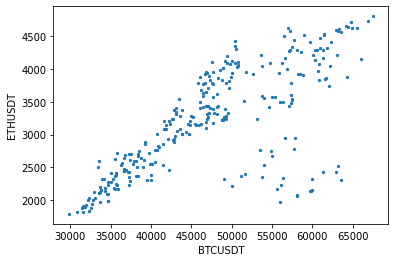

In [ ]:
plt.scatter(df['BTCUSDTClose'], df['ETHUSDTClose'], s=5)
plt.xlabel("BTCUSDT")
plt.ylabel("ETHUSDT")
plt.show()

In [ ]:
# Linear regression

# values converted into a numpy array
X_independent = df.iloc[:,1].values.reshape(-1, 1)
Y_dependent = df.iloc[:,0].values.reshape(-1, 1) 

reg = LinearRegression().fit(X_independent, Y_dependent)

# get beta (angular coef of the linear regression)
beta = reg.coef_;
print('beta = %f' % beta)

# get b coef from (beta*x + b) of the linear regression)
b = reg.intercept_;
print('b = %f' % b)

# get the estimated Y values given X from the model
Y_predict = reg.predict(X_independent);

beta = 8.629289
b = 19635.817578


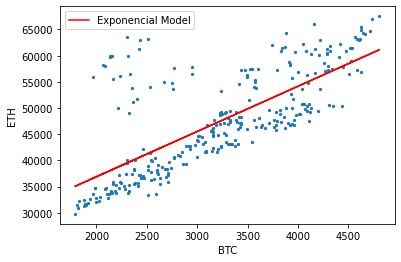

In [ ]:
plt.scatter(X_independent, Y_dependent, s=5)

plt.plot(X_independent, Y_predict, color="red", label='Exponencial Model')

plt.xlabel("BTC")
plt.ylabel("ETH")
plt.legend()
plt.show()

In [ ]:
df['Residual'] = Y_dependent - Y_predict
df

,BTCUSDTClose,ETHUSDTClose,Residual
Time,,,
2021-04-07,55953.45,1963.47,19374.283313
2021-04-08,58077.52,2080.46,20488.812850
2021-04-09,58142.54,2066.87,20671.104881
2021-04-10,59769.13,2133.49,21722.811680
2021-04-11,60002.43,2151.36,21801.906295
...,...,...,...
2022-01-27,37160.10,2424.25,-3395.270247
2022-01-28,37716.56,2544.99,-3880.710541
2022-01-29,38166.84,2601.43,-3917.467585


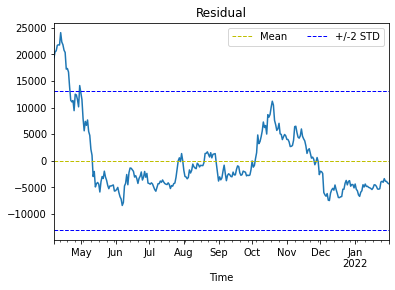

In [ ]:
mean = df['Residual'].mean()
std  = df['Residual'].std()
    
k = 2  # Factor to shift the standard deviation 
up   = mean + std * k
down = mean - std * k

plt.title("Residual")

df['Residual'].plot(x="Major", y="", label='_nolegend_')

plt.axhline(y=mean, color='y', linestyle='--', linewidth=1, label='Mean')
plt.axhline(y=up,   color='b', linestyle='--', linewidth=1, label=f'+/-{k} STD')
plt.axhline(y=down, color='b', linestyle='--', linewidth=1, label='_nolegend_')

plt.legend(loc='upper right',ncol=2)

In [ ]:
split = int(len(df.Residual) / 2)
S1, S2 = df.Residual[0:split], df.Residual[split:]
mean1, mean2 = S1.mean(), S2.mean()
var1, var2 = S1.var(), S2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=888.254438, mean2=-888.254438
variance1=62943495.943186, variance2=21920701.495304


In [ ]:
test_series = adfuller(df['Residual'])
print('ADF Statistic: %f' % test_series[0])
print('p-value: %f' % test_series[1])
print('Critical values:')
for key, value in test_series[4].items():
	print('\t%s: %.3f' % (key, value))
confidence = 1 - test_series[1]
print(f'Confidence: {confidence:.2%}') 

ADF Statistic: -2.914730
p-value: 0.043662
Critical values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Confidence: 95.63%
